# Forecasting Model: NBA (Within Sample Forecast)

We will fit the forecasting model using the salary inforamtion as an IV and compare the performance of the salary forecasting model with betting odds model in terms of accuracy rate and Brier score.

#### Note. The salary information among NBA players were obtained from the web site below. The data were available before the regular season starts so it can be used to "predict" game results for the particular season in advance. Particularly, we used the avarage salary column in the page.
https://www.spotrac.com/nba/contracts/

## 1. Data Preparation

### 1.1) Import Libraries & Dataset

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#Import Data
nba = pd.read_csv("../../Data/Week 4/NBA_Games2.csv")
salary = pd.read_csv("../../Data/Week 4/nba18_salary.csv")

In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### 1.2) Exploratory Data Analysis

In [4]:
#Display Data
display(nba[0:10])
display(salary[0:10])

,CITY,TEAM_NAME,TEAM_ID,NICKNAME,STATE,YEAR_FOUNDED,SEASON_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,WIN
0,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900072,2019-07-12,...,13,23,36,14,15,3,12,24,8.0,1
1,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900060,2019-07-11,...,9,28,37,19,10,8,22,25,-5.0,0
2,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900042,2019-07-09,...,7,27,34,17,5,5,18,21,18.2,1
3,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900023,2019-07-07,...,9,27,36,7,7,10,18,28,-24.0,0
4,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,1521900013,2019-07-06,...,9,30,39,13,11,6,13,21,2.0,0
5,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801220,2019-04-10,...,22,39,61,29,5,7,17,25,-1.0,0
6,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801202,2019-04-07,...,9,39,48,25,2,3,11,28,-8.0,0
7,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801181,2019-04-05,...,10,28,38,21,16,4,14,21,-36.0,0
8,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801168,2019-04-03,...,11,33,44,29,7,7,11,26,8.0,1
9,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801162,2019-04-02,...,11,32,43,26,13,2,11,18,-6.0,0


,Unnamed: 0,TEAM_NAME,Abbreviation,salaries
0,1,Atlanta Hawks,ATL,97118111
1,2,Boston Celtics,BOS,111558063
2,3,Brooklyn Nets,BKN,95696831
3,4,Charlotte Hornets,CHA,117316719
4,5,Chicago Bulls,CHI,72333919
5,6,Cleveland Cavaliers,CLE,142560102
6,7,Dallas Mavericks,DAL,90484648
7,8,Denver Nuggets,DEN,106645851
8,9,Detroit Pistons,DET,118076075
9,10,Golden State Warriors,GSW,139623071


In [5]:
salary.describe().round(decimals = 0)

,Unnamed: 0,salaries
count,30.0,30.0
mean,16.0,111442043.0
std,9.0,16400792.0
min,1.0,72333919.0
25%,8.0,98679635.0
50%,16.0,113636233.0
75%,23.0,121743314.0
max,30.0,142560102.0


### 1.3) Data Cleaning and Organization: 

### NBA data cleaning
This proceeds in several steps:

>1. Filter 2018 regular season records and select columns to be used for analysis. 
>2. Manipulate the MATCHUP column to obtain columns for each team.
>3. Create the dummy home variable.

#### Step 1. Filter 2018 regular season records for forecasting and select columns used for analysis.

In [6]:
# Filter 2018 regular season
# Note: All the pre-season games are recorded with GAME_ID greater than 1000000000.  
nba18 = nba[(nba.SEASON_ID == 22018) & (nba.GAME_ID < 1000000000)]
display(nba18[0:10])

,CITY,TEAM_NAME,TEAM_ID,NICKNAME,STATE,YEAR_FOUNDED,SEASON_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,WIN
5,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801220,2019-04-10,...,22,39,61,29,5,7,17,25,-1.0,0
6,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801202,2019-04-07,...,9,39,48,25,2,3,11,28,-8.0,0
7,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801181,2019-04-05,...,10,28,38,21,16,4,14,21,-36.0,0
8,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801168,2019-04-03,...,11,33,44,29,7,7,11,26,8.0,1
9,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801162,2019-04-02,...,11,32,43,26,13,2,11,18,-6.0,0
10,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801145,2019-03-31,...,15,43,58,36,10,10,9,13,1.0,1
11,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801131,2019-03-29,...,8,33,41,20,5,7,10,22,-20.0,0
12,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801113,2019-03-26,...,9,32,41,30,13,4,16,26,10.0,1
13,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801088,2019-03-23,...,15,34,49,28,8,7,12,25,2.0,1
14,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22018,ATL,21801076,2019-03-21,...,9,34,43,26,8,5,16,23,3.0,1


In [7]:
# Select columns used for forecasting model
nba18 = nba18[['GAME_ID', 'MATCHUP', 'PLUS_MINUS', 'WIN']]

display(nba18[0:10])
nba18.shape

,GAME_ID,MATCHUP,PLUS_MINUS,WIN
5,21801220,ATL vs. IND,-1.0,0
6,21801202,ATL @ MIL,-8.0,0
7,21801181,ATL @ ORL,-36.0,0
8,21801168,ATL vs. PHI,8.0,1
9,21801162,ATL @ SAS,-6.0,0
10,21801145,ATL vs. MIL,1.0,1
11,21801131,ATL vs. POR,-20.0,0
12,21801113,ATL @ NOP,10.0,1
13,21801088,ATL vs. PHI,2.0,1
14,21801076,ATL vs. UTA,3.0,1


(2378, 4)

#### Step 2. Manipulate the MATCHUP column to obtain records for each team
The strings in MATCHUP column is separated at space (" "), and this column should be used for two purposes. Firstly, we will distinguish two teams played in a game as we need to incorporate the salary information for both teams in a match. Secondly, we need to figure out if the game was played at home or away. It should be noted that the data were encoded from the perspective of a team appeared first in the MATCHUP column. So if the match is encoded with "vs", it indicates that the team appeared before "vs" is played at home and if the match is encoded with "@", the team played away. Let's take an example of "ATL vs. IND" in a match column. In this case, ATL is a home team and IND is a away team. 

The command lines below return a data frame with all separated strings in different columns. The resulting dataframe, named "match", is then used to create new columns and the old column (i.e., MATCHUP) should be dropped from nba18 data frame once all the columns are added to the nba18 dataframe. 

In [8]:
# new data frame with split value columns from MATCHUP
match = nba18['MATCHUP'].str.split(" ", n = 2, expand = True) 

display(match[0:10])

,0,1,2
5,ATL,vs.,IND
6,ATL,@,MIL
7,ATL,@,ORL
8,ATL,vs.,PHI
9,ATL,@,SAS
10,ATL,vs.,MIL
11,ATL,vs.,POR
12,ATL,@,NOP
13,ATL,vs.,PHI
14,ATL,vs.,UTA


In [9]:
# Make separate columns in the nba18 data frame from match data frame
nba18['team'] = match[0]
nba18['opp'] = match[2]

# Make separate 'team' column in the nba18 data frame from match data frame
nba18['home_away'] = match[1]

# Drop old column (i.e., MATCHUP) 
nba18.drop(columns = ['MATCHUP'], inplace = True)

In [10]:
# Display dataframe with added columns
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home_away
5,21801220,-1.0,0,ATL,IND,vs.
6,21801202,-8.0,0,ATL,MIL,@
7,21801181,-36.0,0,ATL,ORL,@
8,21801168,8.0,1,ATL,PHI,vs.
9,21801162,-6.0,0,ATL,SAS,@
10,21801145,1.0,1,ATL,MIL,vs.
11,21801131,-20.0,0,ATL,POR,vs.
12,21801113,10.0,1,ATL,NOP,@
13,21801088,2.0,1,ATL,PHI,vs.
14,21801076,3.0,1,ATL,UTA,vs.


#### Step 3. Create a dummy variable denoting if the team played at home (vs.) or away (@). 

In [11]:
# Create a home dummy variable
nba18['home'] = nba18['home_away'].apply(lambda x: 1 if x == 'vs.' else 0)
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home_away,home
5,21801220,-1.0,0,ATL,IND,vs.,1
6,21801202,-8.0,0,ATL,MIL,@,0
7,21801181,-36.0,0,ATL,ORL,@,0
8,21801168,8.0,1,ATL,PHI,vs.,1
9,21801162,-6.0,0,ATL,SAS,@,0
10,21801145,1.0,1,ATL,MIL,vs.,1
11,21801131,-20.0,0,ATL,POR,vs.,1
12,21801113,10.0,1,ATL,NOP,@,0
13,21801088,2.0,1,ATL,PHI,vs.,1
14,21801076,3.0,1,ATL,UTA,vs.,1


In [12]:
# Drop home_away column from data frame
nba18.drop(columns = ['home_away'], inplace = True)

# Display the output
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home
5,21801220,-1.0,0,ATL,IND,1
6,21801202,-8.0,0,ATL,MIL,0
7,21801181,-36.0,0,ATL,ORL,0
8,21801168,8.0,1,ATL,PHI,1
9,21801162,-6.0,0,ATL,SAS,0
10,21801145,1.0,1,ATL,MIL,1
11,21801131,-20.0,0,ATL,POR,1
12,21801113,10.0,1,ATL,NOP,0
13,21801088,2.0,1,ATL,PHI,1
14,21801076,3.0,1,ATL,UTA,1


### Salary data cleaning

In [13]:
display(salary[0:10])

,Unnamed: 0,TEAM_NAME,Abbreviation,salaries
0,1,Atlanta Hawks,ATL,97118111
1,2,Boston Celtics,BOS,111558063
2,3,Brooklyn Nets,BKN,95696831
3,4,Charlotte Hornets,CHA,117316719
4,5,Chicago Bulls,CHI,72333919
5,6,Cleveland Cavaliers,CLE,142560102
6,7,Dallas Mavericks,DAL,90484648
7,8,Denver Nuggets,DEN,106645851
8,9,Detroit Pistons,DET,118076075
9,10,Golden State Warriors,GSW,139623071


In [14]:
# drop unnecessary columns
salary.drop(columns = ['Unnamed: 0', 'TEAM_NAME'], inplace = True)
display(salary[0:10])

,Abbreviation,salaries
0,ATL,97118111
1,BOS,111558063
2,BKN,95696831
3,CHA,117316719
4,CHI,72333919
5,CLE,142560102
6,DAL,90484648
7,DEN,106645851
8,DET,118076075
9,GSW,139623071


#### We need salary records for two competing teams in a match

In [15]:
# change the column header to 'team' to be used for nba18 'team' column 
salary.rename(columns = {'Abbreviation':'team'}, inplace = True)

# merge salary data to nba18 data
nba18=pd.merge(nba18, salary, on=['team'])
nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,salaries
0,21801220,-1.0,0,ATL,IND,1,97118111
1,21801202,-8.0,0,ATL,MIL,0,97118111
2,21801181,-36.0,0,ATL,ORL,0,97118111
3,21801168,8.0,1,ATL,PHI,1,97118111
4,21801162,-6.0,0,ATL,SAS,0,97118111


In [16]:
# same goes with salary records for opponent
# change the column header to 'opp' as a match column to be merged for nba18 'opp' column 
salary.rename(columns = {'team':'opp'}, inplace = True)

# merge salary data to nba18 data
nba18=pd.merge(nba18, salary, on=['opp'])
nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,salaries_x,salaries_y
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654
4,21801183,20.0,1,BOS,IND,0,111558063,94917654


#### Since we used same column headers (i.e., salaries), the resulting columns are distingushed by 'salaries_x'  for team and 'salaries_y' for opponent. We will change the column headers to avoid confusion.

In [17]:
# Change column headers
nba18.rename(columns = {'salaries_x':'team_salary'}, inplace = True)
nba18.rename(columns = {'salaries_y':'opp_salary'}, inplace = True)

nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654
4,21801183,20.0,1,BOS,IND,0,111558063,94917654


In [18]:
# Taking logs of team and opponent salaries
nba18['lg_team_sal']=np.log(nba18['team_salary'])
nba18['lg_opp_sal']=np.log(nba18['opp_salary'])

# taking salary ratio between two teams
nba18['lg_sal_ratio']= nba18['lg_team_sal'] - nba18['lg_opp_sal']

In [19]:
# display output
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,lg_sal_ratio
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535
5,21801130,2.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,0.161535
6,21800607,27.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,0.161535
7,21800127,-1.0,0,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535
8,21800826,-15.0,0,CLE,IND,0,142560102,94917654,18.775274,18.36852,0.406754
9,21800599,-8.0,0,CLE,IND,1,142560102,94917654,18.775274,18.36852,0.406754


## 2. Forecasting with Linear Regression: DV - Point Difference

We will fit the OLS model by using point difference between two teams as DV and log scaled salary raito between two teams as IV

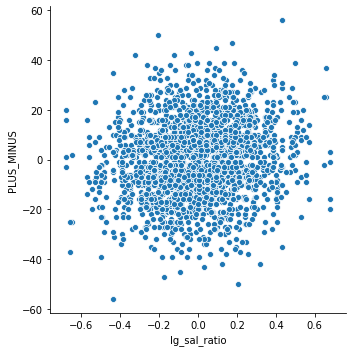

In [20]:
sns.relplot(x = 'lg_sal_ratio', y = 'PLUS_MINUS', data = nba18)

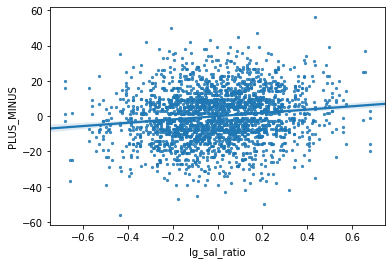

In [21]:
sns.regplot(x = 'lg_sal_ratio', y = 'PLUS_MINUS', data = nba18, scatter_kws={'s':5})

In [22]:
# fit OLS using salary ratio as I.V
PDreg_lm = smf.ols(formula = 'PLUS_MINUS ~ lg_sal_ratio', data=nba18).fit()
PDreg_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PLUS_MINUS   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     46.62
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           1.09e-11
Time:                        10:57:58   Log-Likelihood:                -9736.6
No. Observations:                2378   AIC:                         1.948e+04
Df Residuals:                    2376   BIC:                         1.949e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0034      0.298      0.012      0.991      -0.581       0.588
lg_sal_ratio     9.3502      1.369      6.828      0.000       6.665      12.036
==============================================================================
Omnibus:                        4.414   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.994
Skew:                           0.011   Prob(JB):                       0.0823
Kurtosis:                       3.223   Cond. No.                         4.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# fitted point difference from OLS model
nba18['PDpred1'] = PDreg_lm.predict()
nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,lg_sal_ratio,PDpred1
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535,1.513833


In [24]:
#If the fitted PD >0, we predict the team win (1), otherwise opposing team win(0)
nba18['resPDpred1'] = np.where(nba18['PDpred1']>0, 1, 0)
nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,lg_sal_ratio,PDpred1,resPDpred1
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1


In [25]:
nba18['PDcorrect1'] = np.where(nba18['resPDpred1'] == nba18['WIN'], 1, 0)

In [26]:
sum(nba18['PDcorrect1'])/2378

0.5428931875525652

#### Let's incorporate the home team advantage to the model and see if multiple regression fit the data better than the previous model

In [27]:
# fit OLS using salary ratio and home team advantage as I.V
PDreg2_lm = smf.ols(formula = 'PLUS_MINUS ~ lg_sal_ratio + home', data=nba18).fit()
PDreg2_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PLUS_MINUS   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     67.81
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           2.29e-29
Time:                        10:57:58   Log-Likelihood:                -9693.7
No. Observations:                2378   AIC:                         1.939e+04
Df Residuals:                    2375   BIC:                         1.941e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.7307      0.414     -6.598      0.000      -3.542      -1.919
lg_sal_ratio     9.3501      1.345      6.951      0.000       6.712      11.988
home             5.4682      0.585      9.344      0.000       4.321       6.616
==============================================================================
Omnibus:                        7.125   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                8.698
Skew:                           0.013   Prob(JB):                       0.0129
Kurtosis:                       3.295   Cond. No.                         5.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# fitted point difference from OLS model
nba18['PDpred2'] = PDreg2_lm.predict()
nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,lg_sal_ratio,PDpred1,resPDpred1,PDcorrect1,PDpred2
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,2.951842
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,-2.516393
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,2.951842
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,-2.516393
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1,1,-1.220314


In [29]:
#If the fitted PD >0, we predict the team win (1), otherwise opposing team win(0)
nba18['resPDpred2'] = np.where(nba18['PDpred2']>0, 1, 0)
nba18.head()

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,lg_sal_ratio,PDpred1,resPDpred1,PDcorrect1,PDpred2,resPDpred2
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,2.951842,1
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,-2.516393,0
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,2.951842,1
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,-2.516393,0
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1,1,-1.220314,0


In [30]:
nba18['PDcorrect2'] = np.where(nba18['resPDpred2'] == nba18['WIN'], 1, 0)

In [31]:
sum(nba18['PDcorrect2'])/2378

0.5967199327165685

## 3. Forecasting with Logit Model

Since there are only two outcomes in NBA (W or L), we can fit the logit model for forecasting the game results

In [32]:
Win_lgsal = 'WIN~lg_sal_ratio'
logit_model = smf.glm(formula = Win_lgsal, data = nba18, family=sm.families.Binomial())
result = logit_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    WIN   No. Observations:                 2378
Model:                            GLM   Df Residuals:                     2376
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1633.0
Date:                Fri, 05 Mar 2021   Deviance:                       3266.0
Time:                        10:57:59   Pearson chi2:                 2.38e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0082      0.041     -0.199   

In [33]:
# obtain the fitted probabilities of winning on each game by using the logit model
fittedProbs = result.predict()
print(fittedProbs[0:10])

[0.50397203 0.50397203 0.50397203 0.50397203 0.54033809 0.54033809
 0.54033809 0.54033809 0.60340088 0.60340088]


In [34]:
# Create a binary winning variable by using the fitted probabilities
fittedWin = [1 if x > .5 else 0 for x in fittedProbs]
print(fittedWin[0:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(nba18['WIN'], fittedWin)

array([[684, 512],
       [558, 624]], dtype=int64)

In [36]:
#success rate
(684+624)/2378

0.5500420521446594

## Self Test: 
Obtain the fitted probabilites using the formula above, and then create the predicted game results. Compare the success rate and see if you get the identical results.

In [37]:
#Your Code Here

In [38]:
nba18['predW'] = 1/(1+np.exp(-(-.008220+1.051927*nba18['lg_sal_ratio'])))
nba18['predL'] = 1- nba18['predW'] 
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,lg_sal_ratio,PDpred1,resPDpred1,PDcorrect1,PDpred2,resPDpred2,PDcorrect2,predW,predL
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,2.951842,1,0,0.503972,0.496028
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,-2.516393,0,1,0.503972,0.496028
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,2.951842,1,0,0.503972,0.496028
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,0.022918,0.217729,1,0,-2.516393,0,1,0.503972,0.496028
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1,1,-1.220314,0,0,0.540338,0.459662
5,21801130,2.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1,1,4.247921,1,1,0.540338,0.459662
6,21800607,27.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1,1,4.247921,1,1,0.540338,0.459662
7,21800127,-1.0,0,BOS,IND,0,111558063,94917654,18.530056,18.36852,0.161535,1.513833,1,0,-1.220314,0,1,0.540338,0.459662
8,21800826,-15.0,0,CLE,IND,0,142560102,94917654,18.775274,18.36852,0.406754,3.806682,1,0,1.072492,1,0,0.603401,0.396599
9,21800599,-8.0,0,CLE,IND,1,142560102,94917654,18.775274,18.36852,0.406754,3.806682,1,0,6.540727,1,0,0.603401,0.396599


In [39]:
nba18.loc[nba18.predL > nba18.predW, 'fitted'] = 0
nba18.loc[nba18.predW > nba18.predL, 'fitted'] = 1

In [40]:
nba18['TRUE'] = np.where(nba18['fitted']==nba18['WIN'], 1, 0)
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,...,PDpred1,resPDpred1,PDcorrect1,PDpred2,resPDpred2,PDcorrect2,predW,predL,fitted,TRUE
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,...,0.217729,1,0,2.951842,1,0,0.503972,0.496028,1.0,0
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,...,0.217729,1,0,-2.516393,0,1,0.503972,0.496028,1.0,0
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,...,0.217729,1,0,2.951842,1,0,0.503972,0.496028,1.0,0
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,...,0.217729,1,0,-2.516393,0,1,0.503972,0.496028,1.0,0
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,...,1.513833,1,1,-1.220314,0,0,0.540338,0.459662,1.0,1
5,21801130,2.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,...,1.513833,1,1,4.247921,1,1,0.540338,0.459662,1.0,1
6,21800607,27.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,...,1.513833,1,1,4.247921,1,1,0.540338,0.459662,1.0,1
7,21800127,-1.0,0,BOS,IND,0,111558063,94917654,18.530056,18.36852,...,1.513833,1,0,-1.220314,0,1,0.540338,0.459662,1.0,0
8,21800826,-15.0,0,CLE,IND,0,142560102,94917654,18.775274,18.36852,...,3.806682,1,0,1.072492,1,0,0.603401,0.396599,1.0,0
9,21800599,-8.0,0,CLE,IND,1,142560102,94917654,18.775274,18.36852,...,3.806682,1,0,6.540727,1,0,0.603401,0.396599,1.0,0


In [41]:
Total = nba18['TRUE'].sum()
print(Total/2378)

0.5500420521446594


### Add home team advantage into the logit model

In [42]:
Win_lgsal_hm = 'WIN~lg_sal_ratio + home'
logit_model2 = smf.glm(formula = Win_lgsal_hm, data = nba18, family=sm.families.Binomial())
result = logit_model2.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    WIN   No. Observations:                 2378
Model:                            GLM   Df Residuals:                     2375
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1590.0
Date:                Fri, 05 Mar 2021   Deviance:                       3180.0
Time:                        10:58:01   Pearson chi2:                 2.38e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3951      0.060     -6.636   

In [43]:
nba18['predL2'] = 1/(1+np.exp(-(.3951-1.0909*nba18['lg_sal_ratio']-.7732*nba18['home'])))
nba18['predW2'] = 1- nba18['predL2'] 
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,...,PDcorrect1,PDpred2,resPDpred2,PDcorrect2,predW,predL,fitted,TRUE,predL2,predW2
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,...,0,2.951842,1,0,0.503972,0.496028,1.0,0,0.400567,0.599433
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,...,0,-2.516393,0,1,0.503972,0.496028,1.0,0,0.591483,0.408517
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,...,0,2.951842,1,0,0.503972,0.496028,1.0,0,0.400567,0.599433
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,...,0,-2.516393,0,1,0.503972,0.496028,1.0,0,0.591483,0.408517
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,...,1,-1.220314,0,0,0.540338,0.459662,1.0,1,0.554503,0.445497
5,21801130,2.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,...,1,4.247921,1,1,0.540338,0.459662,1.0,1,0.364863,0.635137
6,21800607,27.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,...,1,4.247921,1,1,0.540338,0.459662,1.0,1,0.364863,0.635137
7,21800127,-1.0,0,BOS,IND,0,111558063,94917654,18.530056,18.36852,...,0,-1.220314,0,1,0.540338,0.459662,1.0,0,0.554503,0.445497
8,21800826,-15.0,0,CLE,IND,0,142560102,94917654,18.775274,18.36852,...,0,1.072492,1,0,0.603401,0.396599,1.0,0,0.487845,0.512155
9,21800599,-8.0,0,CLE,IND,1,142560102,94917654,18.775274,18.36852,...,0,6.540727,1,0,0.603401,0.396599,1.0,0,0.305376,0.694624


In [44]:
nba18.loc[nba18.predL2 > nba18.predW2, 'fitted2'] = 0
nba18.loc[nba18.predW2 > nba18.predL2, 'fitted2'] = 1

In [45]:
nba18['TRUE2'] = np.where(nba18['fitted2']==nba18['WIN'], 1, 0)
display(nba18[0:10])

,GAME_ID,PLUS_MINUS,WIN,team,opp,home,team_salary,opp_salary,lg_team_sal,lg_opp_sal,...,resPDpred2,PDcorrect2,predW,predL,fitted,TRUE,predL2,predW2,fitted2,TRUE2
0,21801220,-1.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,...,1,0,0.503972,0.496028,1.0,0,0.400567,0.599433,1.0,0
1,21800542,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,...,0,1,0.503972,0.496028,1.0,0,0.591483,0.408517,0.0,1
2,21800504,-8.0,0,ATL,IND,1,97118111,94917654,18.391438,18.36852,...,1,0,0.503972,0.496028,1.0,0,0.400567,0.599433,1.0,0
3,21800226,-8.0,0,ATL,IND,0,97118111,94917654,18.391438,18.36852,...,0,1,0.503972,0.496028,1.0,0,0.591483,0.408517,0.0,1
4,21801183,20.0,1,BOS,IND,0,111558063,94917654,18.530056,18.36852,...,0,0,0.540338,0.459662,1.0,1,0.554503,0.445497,0.0,0
5,21801130,2.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,...,1,1,0.540338,0.459662,1.0,1,0.364863,0.635137,1.0,1
6,21800607,27.0,1,BOS,IND,1,111558063,94917654,18.530056,18.36852,...,1,1,0.540338,0.459662,1.0,1,0.364863,0.635137,1.0,1
7,21800127,-1.0,0,BOS,IND,0,111558063,94917654,18.530056,18.36852,...,0,1,0.540338,0.459662,1.0,0,0.554503,0.445497,0.0,1
8,21800826,-15.0,0,CLE,IND,0,142560102,94917654,18.775274,18.36852,...,1,0,0.603401,0.396599,1.0,0,0.487845,0.512155,1.0,0
9,21800599,-8.0,0,CLE,IND,1,142560102,94917654,18.775274,18.36852,...,1,0,0.603401,0.396599,1.0,0,0.305376,0.694624,1.0,0


In [46]:
Total = nba18['TRUE2'].sum()
print(Total/2378)

0.607232968881413


## 4. Forecasting with Betting Odds

In [47]:
# Import the betting odds data
 ## It should be noted that the betting odds are recorded in the form of moneyline odds
 ## The data is recorded from the home team perspective so we don't need a Home dummy variable in this dataset. 

odds = pd.read_csv("../../Data/Week 4/nba_odds18.csv")
odds.head()

,GAME_ID,HOME,AWAY,Score_h,Score_a,odds_h,odds_a
0,21800001,Boston Celtics,Philadelphia 76ers,105,87,-213,179
1,21800002,Golden State Warriors,Oklahoma City Thunder,108,100,-1111,753
2,21800003,Charlotte Hornets,Milwaukee Bucks,112,113,139,-161
3,21800004,Detroit Pistons,Brooklyn Nets,103,100,-250,210
4,21800005,Indiana Pacers,Memphis Grizzlies,111,83,-294,247


In [48]:
# Obtain the home points difference
odds['hpd']= odds['Score_h'] - odds['Score_a']
odds.head()

,GAME_ID,HOME,AWAY,Score_h,Score_a,odds_h,odds_a,hpd
0,21800001,Boston Celtics,Philadelphia 76ers,105,87,-213,179,18
1,21800002,Golden State Warriors,Oklahoma City Thunder,108,100,-1111,753,8
2,21800003,Charlotte Hornets,Milwaukee Bucks,112,113,139,-161,-1
3,21800004,Detroit Pistons,Brooklyn Nets,103,100,-250,210,3
4,21800005,Indiana Pacers,Memphis Grizzlies,111,83,-294,247,28


In [49]:
# Obtain the outcome variable from the perspective of home team
odds['win'] = np.where(odds['hpd'] > 0, 1, 0)
odds.head()

,GAME_ID,HOME,AWAY,Score_h,Score_a,odds_h,odds_a,hpd,win
0,21800001,Boston Celtics,Philadelphia 76ers,105,87,-213,179,18,1
1,21800002,Golden State Warriors,Oklahoma City Thunder,108,100,-1111,753,8,1
2,21800003,Charlotte Hornets,Milwaukee Bucks,112,113,139,-161,-1,0
3,21800004,Detroit Pistons,Brooklyn Nets,103,100,-250,210,3,1
4,21800005,Indiana Pacers,Memphis Grizzlies,111,83,-294,247,28,1


In [50]:
# Calculate the probabilities of each outcome from betting odds
odds['h_prb'] = np.where(odds['odds_h']<0, -(odds['odds_h'])/(-(odds['odds_h'])+100), 100/(odds['odds_h']+100))
odds['a_prb'] = np.where(odds['odds_a']<0, -(odds['odds_a'])/(-(odds['odds_a'])+100), 100/(odds['odds_a']+100))
odds.head()

,GAME_ID,HOME,AWAY,Score_h,Score_a,odds_h,odds_a,hpd,win,h_prb,a_prb
0,21800001,Boston Celtics,Philadelphia 76ers,105,87,-213,179,18,1,0.680511,0.358423
1,21800002,Golden State Warriors,Oklahoma City Thunder,108,100,-1111,753,8,1,0.917424,0.117233
2,21800003,Charlotte Hornets,Milwaukee Bucks,112,113,139,-161,-1,0,0.418410,0.616858
3,21800004,Detroit Pistons,Brooklyn Nets,103,100,-250,210,3,1,0.714286,0.322581
4,21800005,Indiana Pacers,Memphis Grizzlies,111,83,-294,247,28,1,0.746193,0.288184


In [51]:
# Obtain the fitted (i.e., predicted) outcome from the probabilities from the perspective of home team
odds['odds_pred'] = np.where(odds['h_prb'] > odds['a_prb'], 1, 0)
odds.head()

,GAME_ID,HOME,AWAY,Score_h,Score_a,odds_h,odds_a,hpd,win,h_prb,a_prb,odds_pred
0,21800001,Boston Celtics,Philadelphia 76ers,105,87,-213,179,18,1,0.680511,0.358423,1
1,21800002,Golden State Warriors,Oklahoma City Thunder,108,100,-1111,753,8,1,0.917424,0.117233,1
2,21800003,Charlotte Hornets,Milwaukee Bucks,112,113,139,-161,-1,0,0.418410,0.616858,0
3,21800004,Detroit Pistons,Brooklyn Nets,103,100,-250,210,3,1,0.714286,0.322581,1
4,21800005,Indiana Pacers,Memphis Grizzlies,111,83,-294,247,28,1,0.746193,0.288184,1


In [52]:
# Get the accurate results from predicted outcomes
odds['TRUE'] = np.where(odds['odds_pred']==odds['win'], 1, 0)
odds.head()

,GAME_ID,HOME,AWAY,Score_h,Score_a,odds_h,odds_a,hpd,win,h_prb,a_prb,odds_pred,TRUE
0,21800001,Boston Celtics,Philadelphia 76ers,105,87,-213,179,18,1,0.680511,0.358423,1,1
1,21800002,Golden State Warriors,Oklahoma City Thunder,108,100,-1111,753,8,1,0.917424,0.117233,1,1
2,21800003,Charlotte Hornets,Milwaukee Bucks,112,113,139,-161,-1,0,0.418410,0.616858,0,1
3,21800004,Detroit Pistons,Brooklyn Nets,103,100,-250,210,3,1,0.714286,0.322581,1,1
4,21800005,Indiana Pacers,Memphis Grizzlies,111,83,-294,247,28,1,0.746193,0.288184,1,1


In [53]:
# Success rate
Total = odds['TRUE'].sum()
print(Total/1230)

0.6739837398373983


Summary: the success rate of the logit model is about 60% while the success rate of the betting odds model is about 67%. So, the betting odds model performs better than the logit model using salary ratio as a IV.

## 5. Brier Score for Each Model: Salary Ratio Model vs. Betting Odds Model

### 5.1) Brier Score for Salary Ratio Model

In [54]:
nba18['Toutcome'] = np.where(nba18['WIN'] == 1, 1,0)
nba18['Ooutcome'] = np.where(nba18['WIN'] == 0, 1,0)

In [55]:
BrierLogit = ((nba18['predW'] - nba18['Toutcome'])**2 + (nba18['predL'] - nba18['Ooutcome'])**2).sum()/2378

BrierLogit

0.49357808700502787

### 5.2) Brier Score for Betting Odds Model

In [56]:
odds['Houtcome'] = np.where(odds['win'] == 1, 1,0)
odds['Aoutcome'] = np.where(odds['win'] == 0, 1,0)

In [57]:
BrierOdds = ((odds['h_prb'] - odds['Houtcome'])**2 + (odds['a_prb'] - odds['Aoutcome'])**2).sum()/1230

BrierOdds

0.40806220786545916

Summary: The betting odds model had a lower Brier score than the Brier score for the salary ratio model. So, the betting odds model performs better than the salary ratio model in the context of Brier score.

# The End